# Self-Driving Car Engineer Nanodegree Master File


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [1]:
#Collect and initialise all the Useful Packages needed for the math and image processing.
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
from glob import glob
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import os
import math

%matplotlib inline

## Import and Display the images

** Using the glob Library, we determine the path and import the input images. Display these images.

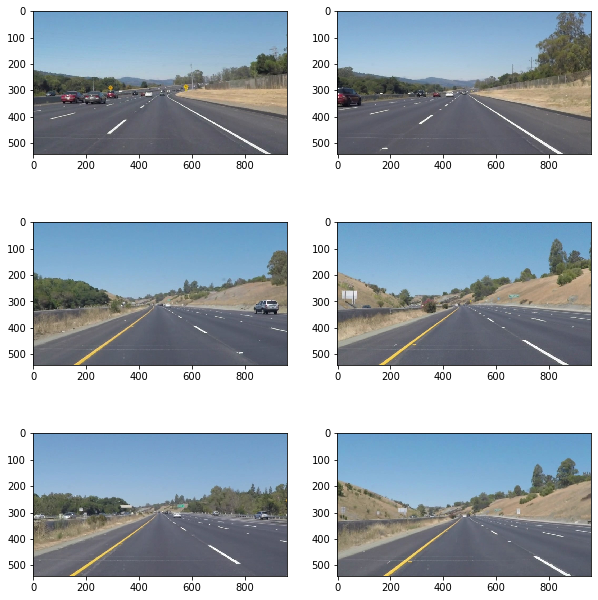

In [2]:
def show_images(images,columns=2,cmap='gray',imgsize=(10,11)):
    #Display only two images per row
    rows = len(images)//columns
    plt.figure(figsize = imgsize)
    for i,image in enumerate(images):
        plt.subplot(rows,columns,i+1)
        plt.imshow(image,cmap = cmap)
    plt.show()

test_images = [plt.imread(path) for path in glob('test_images/*.jpg')]
show_images (test_images)


## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images  
`cv2.cvtColor()` to grayscale or change color  
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def hough_lines(img,rho=1, theta=np.pi/180, threshold=20, min_line_len=20, max_line_gap=300):
    """Applies the hough transformation and deteermines lines"""
    return cv2.HoughLinesP(img, rho, theta, threshold, minLineLength=min_line_len, maxLineGap=max_line_gap)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def getvertices(image):
    """
    This function determines the vertices needed for the region of
    interest.
    """
    x_size = image.shape[1]
    y_size = image.shape[0]

    A = [x_size*0.05,y_size*0.9]
    B = [x_size*0.40,y_size*0.6]
    C = [x_size*0.60,y_size*0.6]
    D = [x_size*0.95,y_size*0.9]

    vertices = np.array([[A,B,C,D]],dtype=np.int32)
    
    return vertices


def draw_lines(img, lines, color=[255, 0, 0], thickness=15):
    """
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    l_image = np.zeros_like(img) # copy the image
    for line in lines:
        if line is not None:
            cv2.line(l_image, *line,  color, thickness)
        
        #for x1,y1,x2,y2 in line:
            #cv2.line(img, (x1, y1), (x2, y2), color, thickness)
    return cv2.addWeighted(img, 1.0, l_image, 0.95, 0.0)

  
def average_lane(lines):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.
    """
    left_lines = []
    left_length = []
    right_lines = []
    right_length = []
    
    for line in lines:
        for x1, y1, x2, y2 in line:
            if x2==x1:
                continue # ignore the vertical lines, slope in INF
            slope = (y2-y1)/(x2-x1)
            intercept = y1 - slope*x1
            length = np.sqrt((y2-y1)**2+(x2-x1)**2)
            if slope < 0: # neg-slope is left-lane since y is reversed in image
                left_lines.append((slope, intercept))
                left_length.append((length))
            else: # pos-slope is right-lane since y is reversed in image
                right_lines.append((slope, intercept))
                right_length.append((length))

    # Averaging of left and right lines to respective lanes.
    if len(left_length) >0:
        left_lane  = np.dot(left_length,  left_lines) /np.sum(left_length)
    else:
        left_lane  = None
    if len(right_length)>0:
        right_lane = np.dot(right_length, right_lines)/np.sum(right_length)
    else:
        right_lane = None
    
    return left_lane, right_lane
    
def getlinecoordinates(y1, y2, line):
    """
    Using the Y coordinates along with the slope and intercept, we determine the
    X coordinates using the line equation of the line segment.
    Then, its the position of each of the lines and extrapolated to the top and bottom of the lane.
    """
    if line is None:
        return None
    
    #extract the slope and intercept information from the line.
    slope, intercept = line
    
    x1 = int((y1 - intercept)/slope)
    x2 = int((y2 - intercept)/slope)
    y1 = int(y1)
    y2 = int(y2)
    
    return ((x1, y1), (x2, y2))

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

## Identify Lanes from the images

Use Rapid Tables for colour definition.  
**RGB for white(255,255,255) and RGB for yellow (255,255,0) / (153,153,0).**

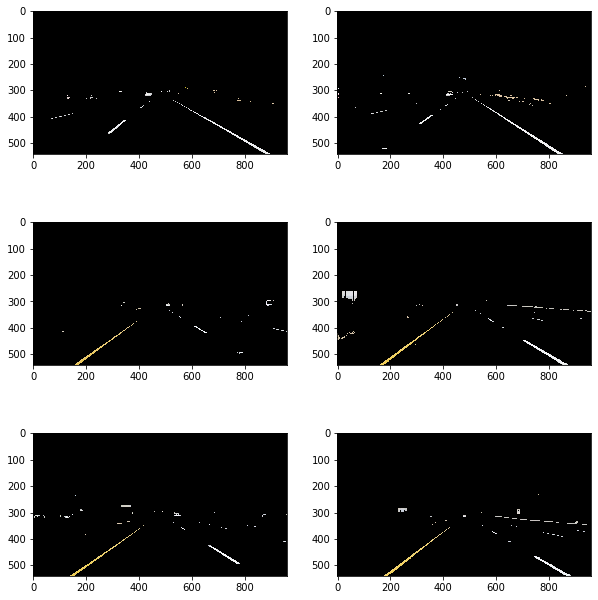

In [4]:
def extractwhiteyellowlanes(image):
    #White Extraction
    whitelines = cv2.inRange(image,np.uint8([200,200,200]),np.uint8([255,255,255]))
    #Yellow Extraction
    yellowlines = cv2.inRange(image,np.uint8([190,190,0]),np.uint8([255,255,255]))
    mask = cv2.bitwise_or(whitelines,yellowlines)
    mask_img = cv2.bitwise_and(image,image,mask=mask)
    return mask_img
whiteyellowlanes = list(map(extractwhiteyellowlanes,test_images))
show_images(list(map(extractwhiteyellowlanes,whiteyellowlanes)))

## Convert image in HSL Colour Space



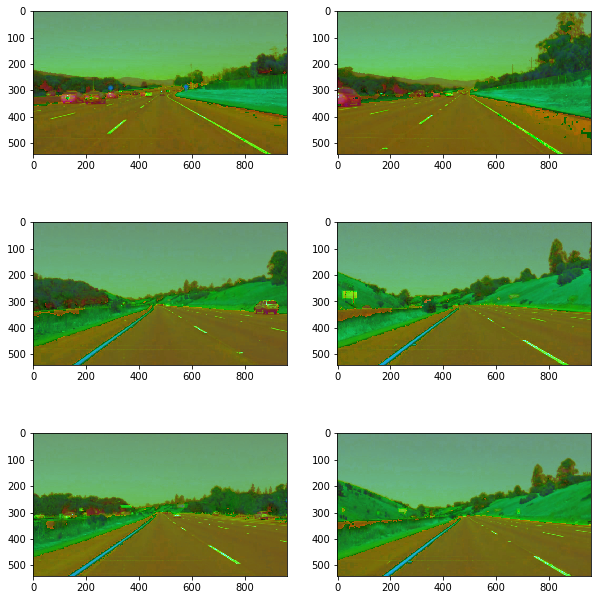

In [5]:
def convert_to_hls(image):
    return cv2.cvtColor(image,cv2.COLOR_RGB2HLS)

show_images(list(map(convert_to_hls,test_images)))

## Detect Lanes in HSL Image


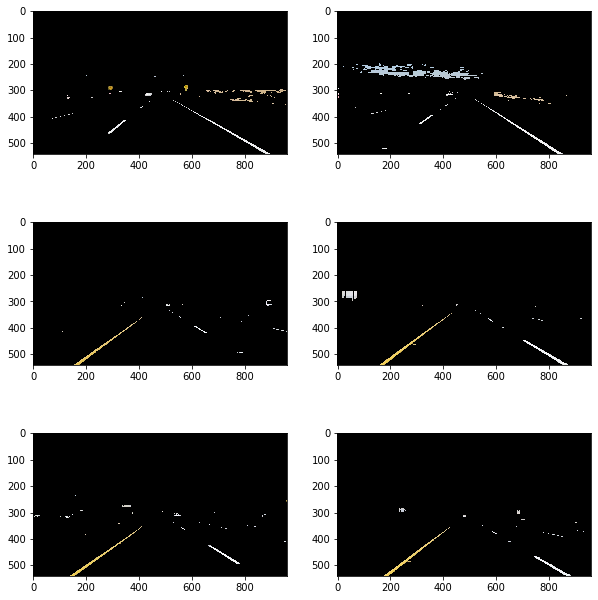

In [6]:
def extracthslwhiteyellowlanes(image):
    hlsimage = convert_to_hls(image)
    white_mask = cv2.inRange(hlsimage,np.uint8([  0,200,0]),np.uint8([255,255,255]))
    yellow_mask = cv2.inRange(hlsimage,np.uint8([ 10,0,100]),np.uint8([40,255,255]))
    combined_mask = cv2.bitwise_or(white_mask,yellow_mask)
    masked_img = cv2.bitwise_and(image,image,mask=combined_mask)
    return masked_img

hsl_lane_images = list(map(extracthslwhiteyellowlanes,test_images))
show_images(hsl_lane_images)

## Gray Scaling

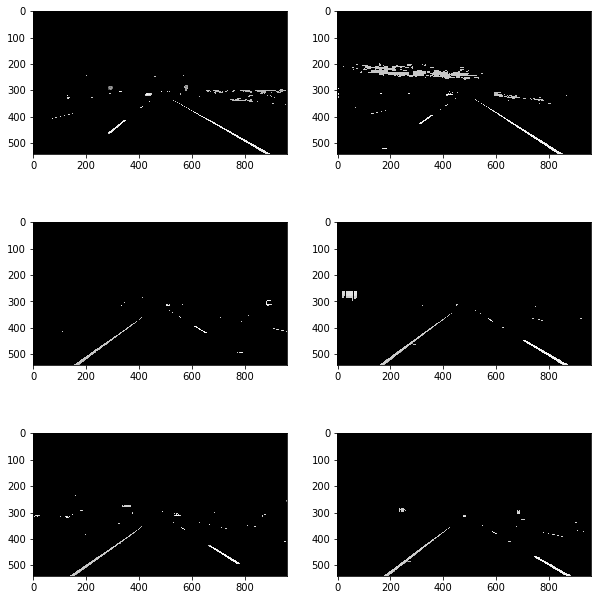

In [7]:
gray_images = list(map(grayscale,hsl_lane_images))
show_images(gray_images)

## Gaussian Blur Image Filtering

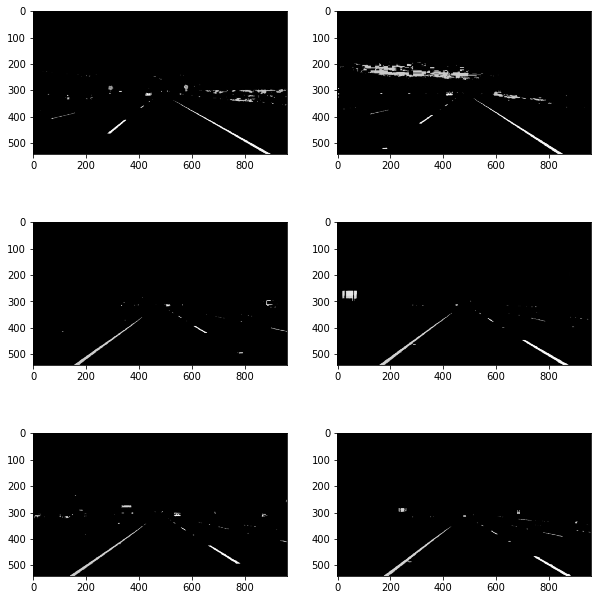

In [8]:
smooth_edge_images = list(map(lambda image: gaussian_blur(image,5),gray_images))
show_images(smooth_edge_images)

## Canny Edge Detection

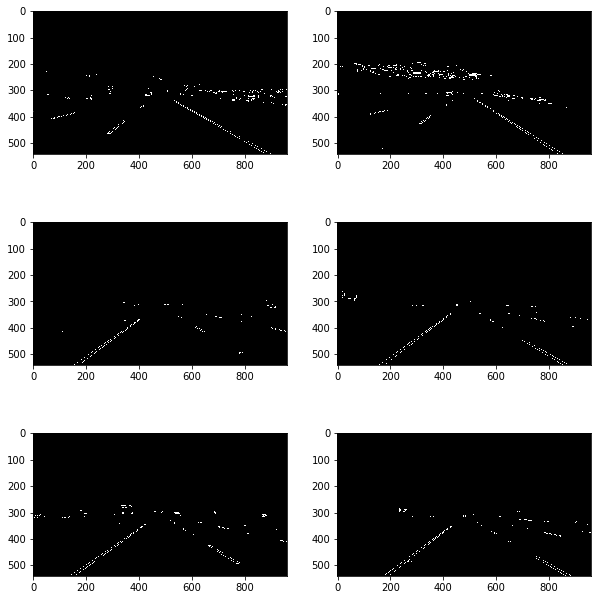

In [9]:
canny_edges = list(map(lambda image:canny(image,50,150),smooth_edge_images))
show_images(canny_edges)

## Defining Region of Interest

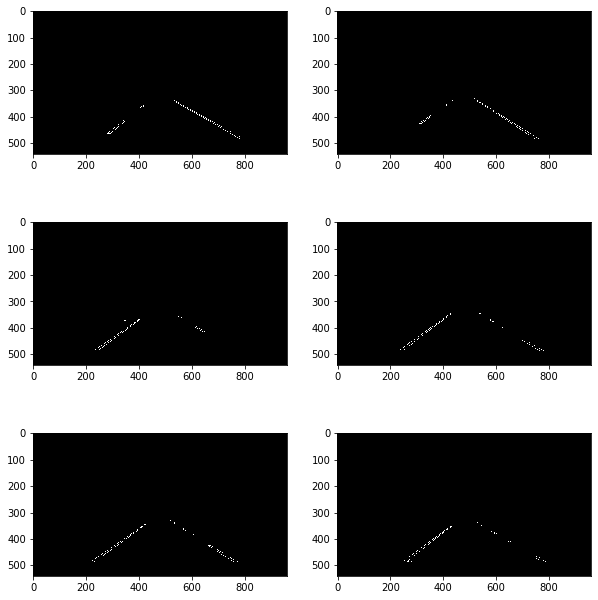

In [10]:
#Define the vertices for the region of interest
x_size = canny_edges[0].shape[1]
y_size = canny_edges[0].shape[0]

A = [x_size*0.05,y_size*0.9]
B = [x_size*0.40,y_size*0.6]
C = [x_size*0.60,y_size*0.6]
D = [x_size*0.95,y_size*0.9]

vertices = np.array([[A,B,C,D]],dtype=np.int32)

mask_images = list(map(lambda image:region_of_interest(image,vertices),canny_edges))

show_images(mask_images)

## Hough Transformation

In [11]:
#hough_images = list(map(lambda image:hough_lines(image,rho=1, theta=np.pi/180, threshold=20, min_line_len=20, max_line_gap=300),mask_images))
#show_images(hough_images)
houghlines = list(map(hough_lines,mask_images))

## Average/Extrapolate the line segments

Map out the full extent of the lane.


In [12]:
def finallines(image, lines):
    """
    Find the average line for left and right and return in xy coordinate form
    """
    leftlane, rightlane = average_lane(lines)

    y1 = image.shape[0] #Extend the average line until the bottom of the image
    y2 = y1*0.6 # Extend the average line until approximately the middle height of the image

    left_line  = getlinecoordinates(y1, y2, leftlane)
    right_line = getlinecoordinates(y1, y2, rightlane)
    
    #Coordinate check of the lines to be drawn on the original image
    
    return left_line, right_line

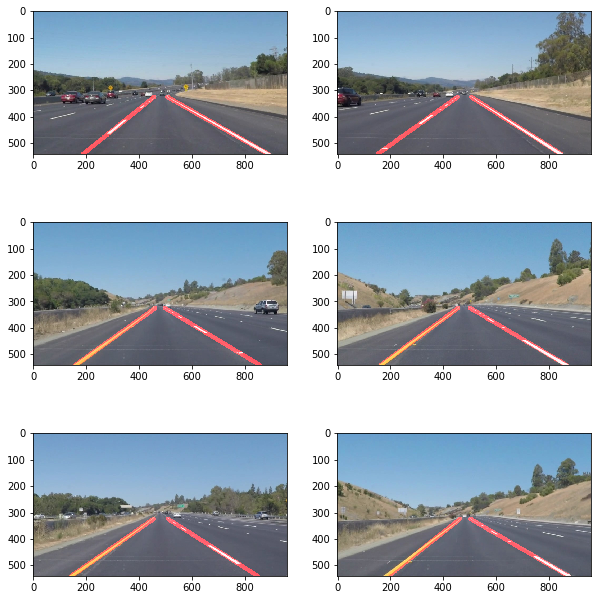

In [13]:
final_images = []
for image, lines in zip(test_images, houghlines): #Iterate each original image with the respective hough lines
    final_images.append(draw_lines(image, finallines(image, lines)))

show_images(final_images)

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`


In [14]:
    def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
        hsl_lane_video = extracthslwhiteyellowlanes(image)
        gray_video = grayscale(hsl_lane_video)
        smooth_edge_video = gaussian_blur(gray_video,5)
        canny_edges_video = canny(smooth_edge_video,50,150)
        video_vertices = getvertices(canny_edges_video)
        mask_video = region_of_interest(canny_edges_video,video_vertices)
        houghlines_video = hough_lines(mask_video)
    
        left_line_video, right_line_video = finallines(image,houghlines_video)

        return draw_lines(image, (left_line_video, right_line_video))

Let's try the one with the solid white lane on the right first ...

In [15]:
white_output = 'test_videos_output/solidWhiteRight_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip2 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip2.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight_output.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight_output.mp4


100%|█████████▉| 221/222 [00:04<00:00, 49.53it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight_output.mp4 

Wall time: 5.02 s


Now for the one with the solid yellow lane on the left. This one's more tricky!

In [16]:
white_output = 'test_videos_output/solidYellowLeft_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidYellowLeft.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft_output.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft_output.mp4


100%|█████████▉| 681/682 [00:12<00:00, 54.06it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft_output.mp4 

Wall time: 13.1 s


## Writeup and Submission

Writeup is provided in the WriteUp_P1_Submission.md file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

***The pipeline does not seem flawless during the change in lane color. Further investigation would be necessary***

In [17]:
white_output = 'test_videos_output/challenge_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip3 = VideoFileClip("test_videos/challenge.mp4")
white_clip = clip3.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge_output.mp4
[MoviePy] Writing video test_videos_output/challenge_output.mp4


100%|██████████| 251/251 [00:08<00:00, 28.54it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge_output.mp4 

Wall time: 9.69 s
